In [120]:
import numpy as np
import matplotlib.pyplot as plt

from numpy.typing import NDArray
from scipy.signal import lfilter

plt.rcParams.update({"axes.grid": True, "font.size": 14})

In [121]:
def bin2dec(bin: NDArray, n: int) -> NDArray:
    bin = bin.reshape(-1, n)
    bin = np.sum(bin * 2 ** np.arange(n)[::-1], axis=1)
    return bin


def qammod(data: NDArray, M: int) -> NDArray:
    """
    QAM modulation function.

    Parameters:
    data : array_like
        The input data symbols to be modulated.
    M : int
        The order of the QAM modulation (e.g., 16 for 16-QAM).

    Returns:
    modulated_signal : ndarray
        The modulated QAM signal.
    """

    # Generate the constellation points
    constellation = np.array(
        [
            complex(i, j)
            for i in range(-int(np.sqrt(M)) + 1, int(np.sqrt(M)), 2)
            for j in range(-int(np.sqrt(M)) + 1, int(np.sqrt(M)), 2)
        ]
    )

    # Map input data to constellation points
    modulated_signal = constellation[data]

    return modulated_signal

In [122]:
# info = np.array(list(map(int, "0001100001011100")))
M = 16  # Número de símbolos da modulação
n = np.log2(M).astype(int)  # Número de bits por símbolo

Rb = 1024  # Taxa de bits [bps]
Tb = 1 / Rb  # Tempo de bit

Rs = Rb / n  # Taxa de símbolos [baud]
Ts = 1 / Rs  # Tempo de símbolo

N = 100  # Fator de superamostragem
Fa = N * Rs  # Frequência de amostragem
Ta = 1 / Fa  # Tempo de amostragem

fc = 4000  # Frequência da portadora

n_bits = n * 1000  # Número de bits a serem transmitidos
t_tx = n_bits * Tb  # Tempo total de transmissão
t = np.arange(0, t_tx, Ta)  # Eixo do tempo

In [123]:
info = np.random.randint(0, 2, n_bits)

symbols = bin2dec(info, n)
symbols

array([11,  5,  4, 12,  5,  1,  8,  3,  0,  5,  3, 15, 14,  8,  7,  8, 15,
       14,  3,  9,  4, 15, 11,  3,  7,  9,  2, 11, 10, 11,  3,  8, 15,  4,
        0,  5, 14,  5,  4,  2,  1,  4,  0,  8,  0,  9,  4, 13,  9,  3,  0,
        5,  4, 14, 11, 14, 12, 11,  7,  6,  5,  0,  1, 15, 12, 11,  9, 14,
        9, 13, 10,  8,  9,  2, 13, 13,  9, 10,  0, 14,  5,  3, 12, 11,  8,
        2, 11,  5, 10, 14,  0, 14,  2,  0,  8, 15,  5,  8,  8,  0, 14, 11,
        9, 15,  6, 10, 15, 12, 13,  9, 15, 11,  8, 10,  6,  8, 15,  6,  0,
        6, 13,  5,  7, 11,  3,  8,  2, 13, 10, 15,  3, 13, 12,  7,  7,  3,
       13,  3,  9,  0,  6,  5, 12, 11,  0,  8, 13, 12, 11, 14,  2,  7,  7,
       12, 15, 15,  2,  8,  8,  0,  2,  3, 11,  5,  4,  9, 10,  2,  5,  6,
        1,  7,  0,  0,  5,  3,  7, 15,  4,  7,  8,  8,  5, 13,  0, 11, 14,
       15,  0, 13, 10,  6, 14, 11,  9,  9, 10,  1,  9,  8, 11, 13,  1,  2,
       11,  1, 10, 15,  4, 11,  4, 10, 10, 11,  9, 10,  4,  1,  3,  5,  3,
        3,  2,  8, 12, 11

In [124]:
modulated = qammod(symbols, M)
modulated

array([ 1.+3.j, -1.-1.j, -1.-3.j,  3.-3.j, -1.-1.j, -3.-1.j,  1.-3.j,
       -3.+3.j, -3.-3.j, -1.-1.j, -3.+3.j,  3.+3.j,  3.+1.j,  1.-3.j,
       -1.+3.j,  1.-3.j,  3.+3.j,  3.+1.j, -3.+3.j,  1.-1.j, -1.-3.j,
        3.+3.j,  1.+3.j, -3.+3.j, -1.+3.j,  1.-1.j, -3.+1.j,  1.+3.j,
        1.+1.j,  1.+3.j, -3.+3.j,  1.-3.j,  3.+3.j, -1.-3.j, -3.-3.j,
       -1.-1.j,  3.+1.j, -1.-1.j, -1.-3.j, -3.+1.j, -3.-1.j, -1.-3.j,
       -3.-3.j,  1.-3.j, -3.-3.j,  1.-1.j, -1.-3.j,  3.-1.j,  1.-1.j,
       -3.+3.j, -3.-3.j, -1.-1.j, -1.-3.j,  3.+1.j,  1.+3.j,  3.+1.j,
        3.-3.j,  1.+3.j, -1.+3.j, -1.+1.j, -1.-1.j, -3.-3.j, -3.-1.j,
        3.+3.j,  3.-3.j,  1.+3.j,  1.-1.j,  3.+1.j,  1.-1.j,  3.-1.j,
        1.+1.j,  1.-3.j,  1.-1.j, -3.+1.j,  3.-1.j,  3.-1.j,  1.-1.j,
        1.+1.j, -3.-3.j,  3.+1.j, -1.-1.j, -3.+3.j,  3.-3.j,  1.+3.j,
        1.-3.j, -3.+1.j,  1.+3.j, -1.-1.j,  1.+1.j,  3.+1.j, -3.-3.j,
        3.+1.j, -3.+1.j, -3.-3.j,  1.-3.j,  3.+3.j, -1.-1.j,  1.-3.j,
        1.-3.j, -3.-

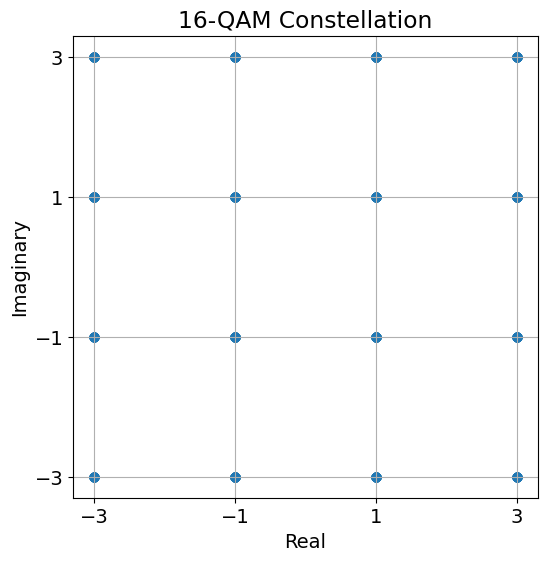

In [125]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6))

ax.scatter(modulated.real, modulated.imag)

ax.set_xticks(np.arange(-3, 4, 2))
ax.set_yticks(np.arange(-3, 4, 2))

ax.set_title("16-QAM Constellation")
ax.set_xlabel("Real")
ax.set_ylabel("Imaginary")

plt.show()

In [126]:
I = modulated.real
Q = modulated.imag

PAM_filter = np.ones(N)

# NRZ upsample
I_4pam = np.repeat(I, N)
I_4pam = lfilter(PAM_filter, 1, I_4pam)

Q_4pam = np.repeat(Q, N)
Q_4pam = lfilter(PAM_filter, 1, Q_4pam)


print("I:", I)
print("Q:", Q)

I: [ 1. -1. -1.  3. -1. -3.  1. -3. -3. -1. -3.  3.  3.  1. -1.  1.  3.  3.
 -3.  1. -1.  3.  1. -3. -1.  1. -3.  1.  1.  1. -3.  1.  3. -1. -3. -1.
  3. -1. -1. -3. -3. -1. -3.  1. -3.  1. -1.  3.  1. -3. -3. -1. -1.  3.
  1.  3.  3.  1. -1. -1. -1. -3. -3.  3.  3.  1.  1.  3.  1.  3.  1.  1.
  1. -3.  3.  3.  1.  1. -3.  3. -1. -3.  3.  1.  1. -3.  1. -1.  1.  3.
 -3.  3. -3. -3.  1.  3. -1.  1.  1. -3.  3.  1.  1.  3. -1.  1.  3.  3.
  3.  1.  3.  1.  1.  1. -1.  1.  3. -1. -3. -1.  3. -1. -1.  1. -3.  1.
 -3.  3.  1.  3. -3.  3.  3. -1. -1. -3.  3. -3.  1. -3. -1. -1.  3.  1.
 -3.  1.  3.  3.  1.  3. -3. -1. -1.  3.  3.  3. -3.  1.  1. -3. -3. -3.
  1. -1. -1.  1.  1. -3. -1. -1. -3. -1. -3. -3. -1. -3. -1.  3. -1. -1.
  1.  1. -1.  3. -3.  1.  3.  3. -3.  3.  1. -1.  3.  1.  1.  1.  1. -3.
  1.  1.  1.  3. -3. -3.  1. -3.  1.  3. -1.  1. -1.  1.  1.  1.  1.  1.
 -1. -3. -3. -1. -3. -3. -3.  1.  3.  1.  3. -1.  1. -3.  1.  3.  1. -1.
  1.  3. -1.  1. -3. -1.  3. -1.  3. -3. -1.  3.

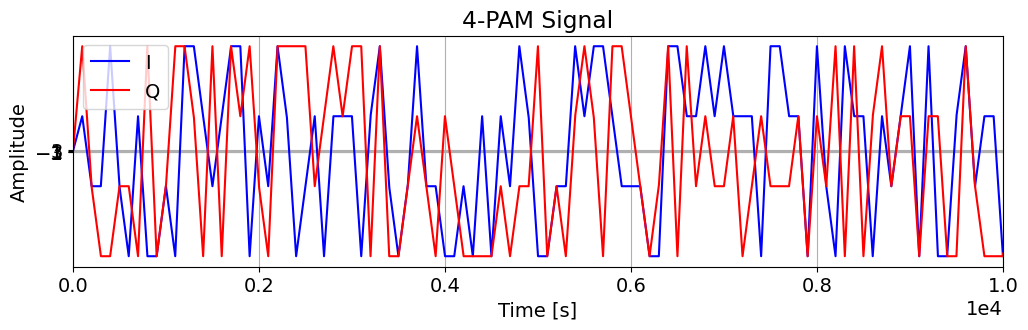

In [127]:
fig, ax = plt.subplots(1, 1, figsize=(12, 3))

ax.plot(I_4pam, "b")
ax.plot(Q_4pam, "r")


ax.set_xlim(0, 10000)
ax.set_yticks(np.arange(-3, 4, 2))
ax.ticklabel_format(axis="x", style="sci", scilimits=(0, 0))

ax.set_title("4-PAM Signal")
ax.set_xlabel("Time [s]")
ax.set_ylabel("Amplitude")

ax.legend(["I", "Q"])

plt.show()

In [128]:
tx = I_4pam * np.cos(2 * np.pi * fc * t) - Q_4pam * np.sin(2 * np.pi * fc * t)

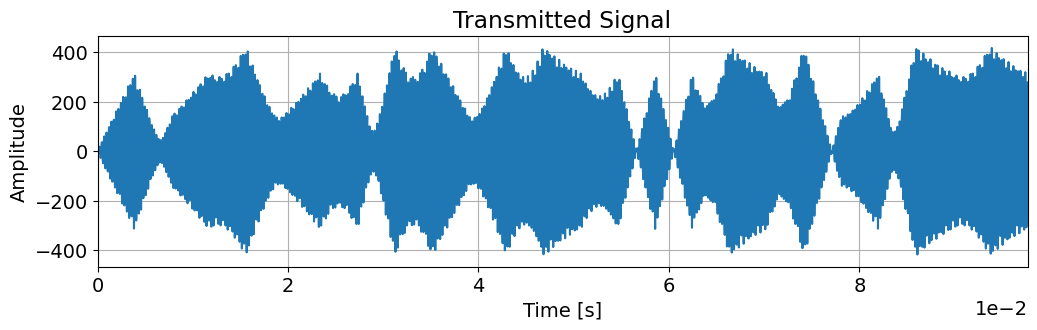

In [132]:
fig, ax = plt.subplots(1, 1, figsize=(12, 3))

ax.plot(t, tx)

ax.set_xlim(0, 100 * Tb)

ax.set_title("Transmitted Signal")
ax.set_xlabel("Time [s]")
ax.set_ylabel("Amplitude")

ax.ticklabel_format(axis="x", style="sci", scilimits=(0, 0))

plt.show()

### Demodulação

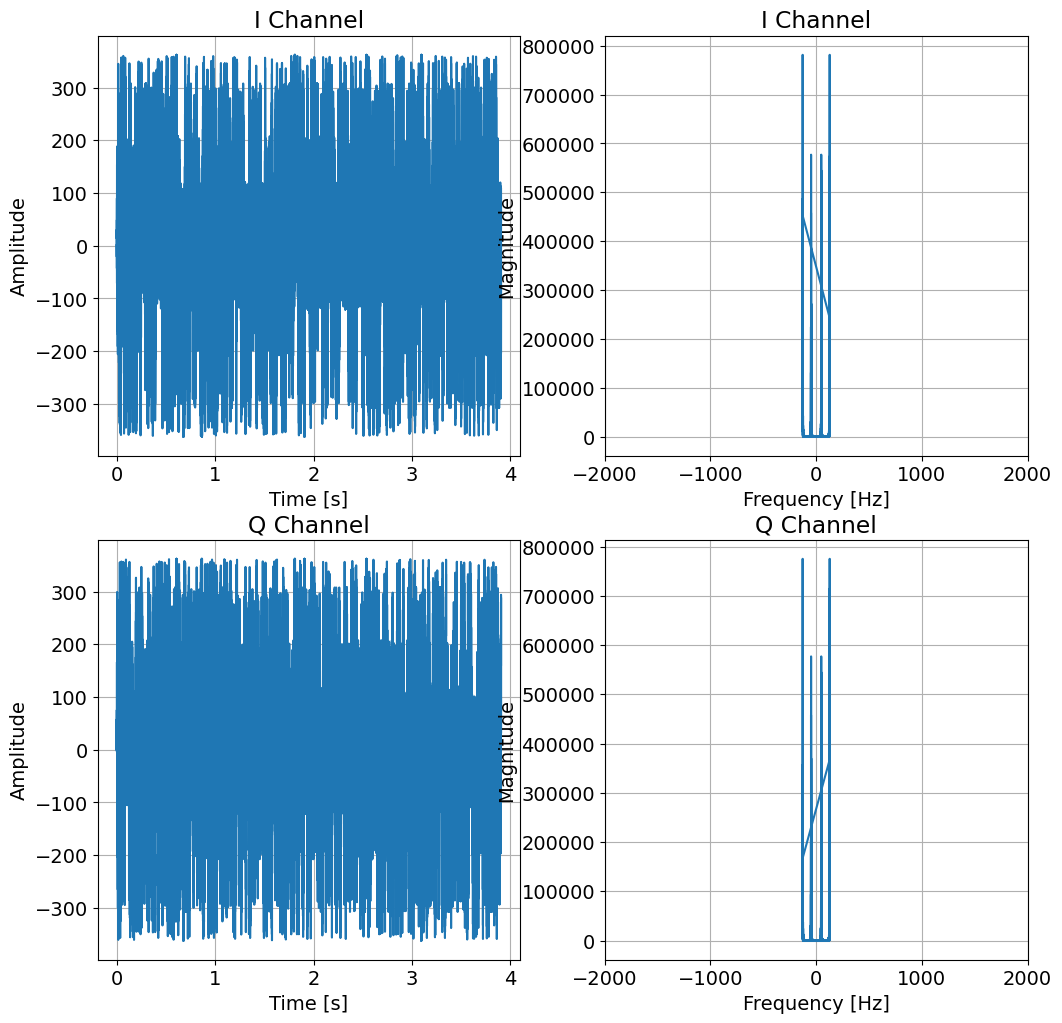